# RTF Model for predicting zone with MFCC


### Model Description
This notebook implements a Random Forest (RTF) model to classify the impact zone (C, S, V) of a racket based on sound features extracted from .wav audio files. Instead of using energy per frequency band, the model leverages Mel-Frequency Cepstral Coefficients (MFCC) to represent the spectral characteristics of each impact sound. The MFCCs are computed using the librosa library, and the mean values across time are used as features. The data is preprocessed to ensure uniform shape, then split into training and test sets. A grid search over hyperparameters (number of estimators, max depth, minimum samples per split) is performed to evaluate model performance using accuracy scores. The MFCC features are also visualized to provide insight into the audio structure.

# Import Libraries

In [2]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import sys
from sklearn.ensemble import RandomForestClassifier


### Import Tools Functions

In [3]:
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

Readwav function

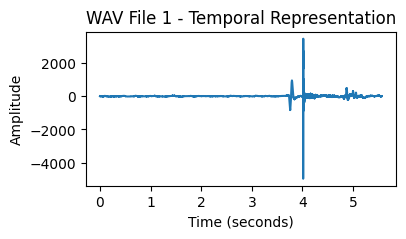

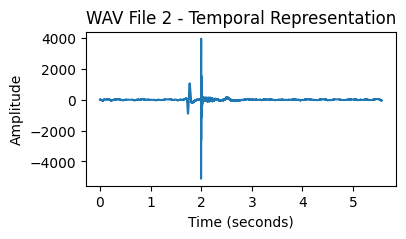

In [4]:
from readWavFolder import readWavFolder
    
samplerateVect,testWavFileVect,files = readWavFolder("../../../Data/Sound/P1")

for i, wav_data in enumerate(testWavFileVect[:2]):
    plt.figure(figsize=(4, 2))
    time_axis = [x / samplerateVect[i] for x in range(len(wav_data))]
    plt.plot(time_axis, wav_data[:, 1])  # Plot only the n channel
    plt.title(f"WAV File {i + 1} - Temporal Representation")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()


Spectrum

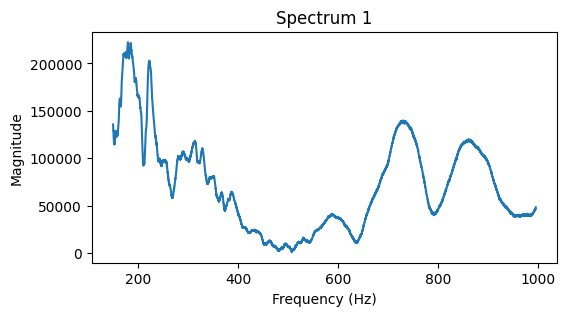

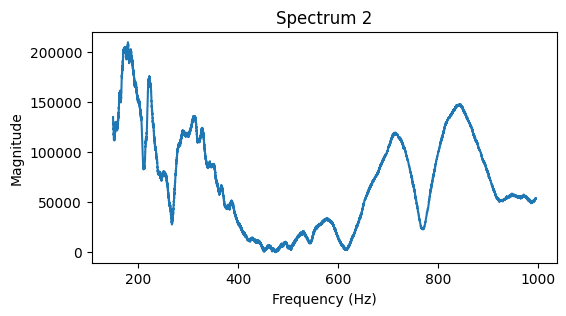

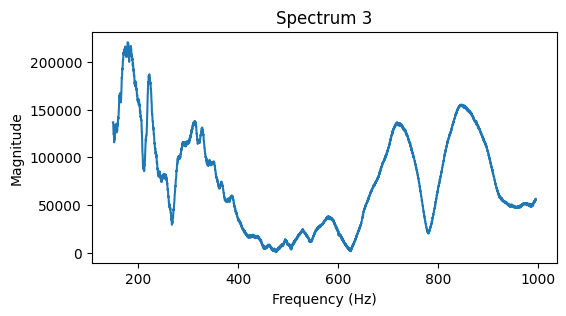

In [5]:
from spectrumFromSignal import spectrumFromSignal


spectrumVect=[]

for i in range(len(testWavFileVect)):
    spectrum,freqs= spectrumFromSignal(testWavFileVect[i],samplerateVect[i])
    spectrumVect.append(spectrum)

for idx, spectrum in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs[:len(spectrum)], spectrum)  # Associate frequencies with the spectrum
    plt.title(f"Spectrum {idx + 1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()



Energy

In [6]:
from energy_per_frequency_band_from_spectrum import energy_per_frequency_band_from_spectrum

# Main

### Data Preparation and Label Encoding

In [7]:
import re
import numpy as np
import pandas as pd
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from readWavFolder import readWavFolder

# Liste des types de raquettes et zones
racket_names = {"RB": 1, "RO": 2, "RR": 3, "RV": 4}
zone_names = {"C": 1, "S": 2, "V": 3}

results = []

c = 0  # canal : 0 = gauche, 1 = droite

X_Features = []
Y_Label = []

for raquetteType in racket_names:
    dossier_raquette = f"../../../Data/Sound/P1"
    samplerateVect, WavFileVect, filesName = readWavFolder(dossier_raquette)

    for i in range(len(WavFileVect)):
        filename = filesName[i]

        # Extraire la zone depuis le nom du fichier
        match = re.search(r'_(C|S|V)_', filename)
        if match:
            zone = match.group(1)
        else:
            continue  # ignorer les fichiers non valides

        wav_data = WavFileVect[i]

        # Gérer mono/stéréo
        if wav_data.ndim == 1:
            wav_data = np.stack((wav_data, wav_data), axis=-1)
        elif wav_data.shape[1] == 1:
            wav_data = np.concatenate((wav_data, wav_data), axis=1)

        # Extraire la MFCC du canal souhaité
        signal = wav_data[:, c]
        sr = samplerateVect[i]

        mfcc = librosa.feature.mfcc(y=signal.astype(np.float32), sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)  # Moyenne sur le temps

        X_Features.append(mfcc_mean)
        Y_Label.append(zone)

# Padding (au cas où certaines MFCC ont longueur différente, même si peu probable ici)
max_length = max(len(f) for f in X_Features)
X_padded = [np.pad(f, (0, max_length - len(f)), constant_values=0) for f in X_Features]

X = np.array(X_padded)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y_Label)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

n_estimators_range = range(10, 101, 10)
max_depth_range = [None, 10, 20, 30, 40]
min_samples_split_range = [2, 5, 10]

for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)
            accuracy_train = accuracy_score(y_train, rf.predict(X_train))

            channel_name = "Left" if c == 0 else "Right"

            results.append({
                'Chanel_Name': channel_name,
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Export des résultats
results_df = pd.DataFrame(results)
# results_df.to_excel("RTF_ZONE_P1_MFCC.xlsx", index=False)
print("DONE")


DONE


## Results and Visualisation

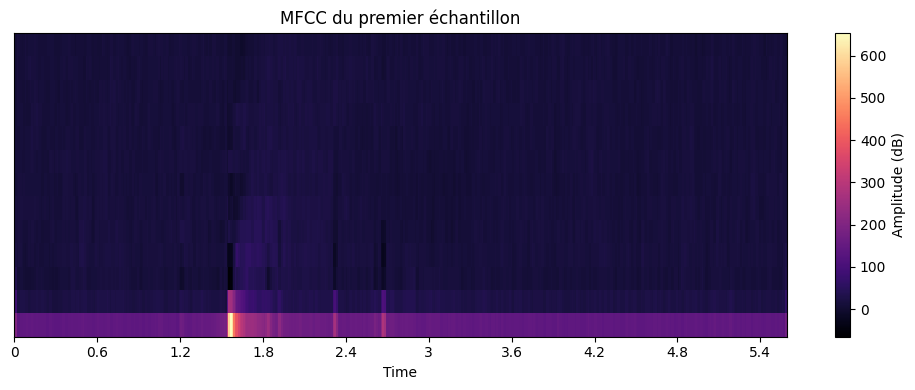

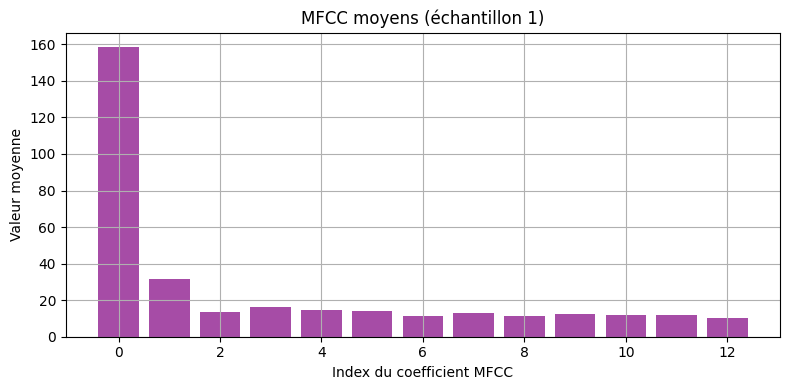

In [9]:
import matplotlib.pyplot as plt
import librosa.display

# Supposons que "signal" et "sr" correspondent au premier échantillon
# Tu peux les récupérer dans ta boucle avec un flag (comme 'displayed = False')
displayed = False
if not displayed:
    # Extraire les MFCC du premier échantillon
    mfcc = librosa.feature.mfcc(y=signal.astype(np.float32), sr=sr, n_mfcc=13)

    # Affichage sous forme d'image (spectrogramme MFCC)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar(label='Amplitude (dB)')
    plt.title("MFCC du premier échantillon")
    plt.tight_layout()
    plt.show()

    # Affichage des MFCC moyens (profil global)
    mfcc_mean = np.mean(mfcc, axis=1)
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(mfcc_mean)), mfcc_mean, color='purple', alpha=0.7)
    plt.title("MFCC moyens (échantillon 1)")
    plt.xlabel("Index du coefficient MFCC")
    plt.ylabel("Valeur moyenne")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    displayed = True


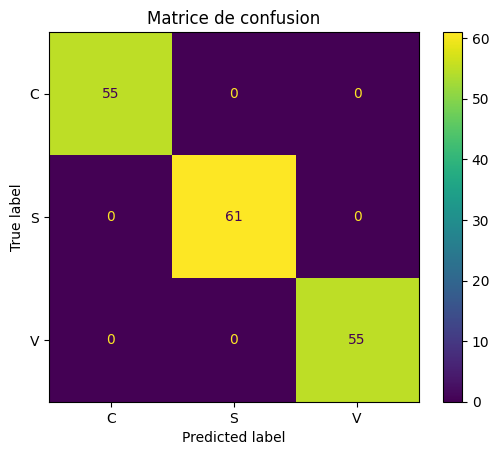

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()
